# Generative Adversarial Networks (GAN)

### A simple example based on LiveLessons course

This notebook is a simple example of Generative Adversarial Network (GAN). The data are collected from https://quickdraw.withgoogle.com/ which is a collection of drawings.

We use **bicycle** drawings for this example. In order to download the data, go to https://github.com/googlecreativelab/quickdraw-dataset and find the link for `.npy` format of data. Click on the link and search for **bicycle**. Put your data in google cloud or other place such that the data can be imported in this code and continue...

### What is a GAN?
According to [Wikipedia:]()
>A **generative adversarial network (GAN)** is a class of machine learning systems invented by Ian Goodfellow and his colleagues in 2014. Two neural networks contest with each other in a game. Given a training set, this technique learns to generate new data with the same statistics as the training set. For example, a GAN trained on photographs can generate new photographs that look at least superficially authentic to human observers, having many realistic characteristics.

<img alt="an image of GAN architecture" src="https://skymind.ai/images/wiki/GANs.png" width="800">

The image is taken from <a href="https://skymind.ai/wiki/generative-adversarial-network-gan">here</a>.


In the above image, it is show how a GAN works. There is a random noise which is feed into the *Generator* network. The generator network prodcues fake images. There are three networks in a GAN:
- Discriminator: To discriminate real images from fake images
- Generator: To generate fake images
- Adversarial: Generator + Discriminator (sequential network of generator and discriminator)

The main idea behind GAN is to train networks so that the generator produces fake images which are not distinguishable from real images by the discriminator.

In order to train the discriminator, we label the real data as 0 and the fake data as 1. After this labeling, the training of the discriminator is just a suprvised learning problem. We can consider each epoch of training as two steps.
The steps are:
- Step 1:
  - use generator to produce fake images
  - label fake images and real images as fake and real, respectively
  - feed both fake and real image to discriminator
  - train the discriminator (update the discriminator parameters)
- Step 2:
  - use generator to produce fake images
  - label **fake** images as **real**
  - feed fake images (which are labeled as real) to discriminator
  - train adversarial network ( do **NOT** update the discriminator parameters, but update the generator parameters)


### Let's start to GAN bicycles!

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
!nvidia-smi # uncomment or comment this line if wanted to know which GPUs are available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Mon Sep  9 16:07:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Load packages

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import UpSampling2D, Conv2DTranspose, Reshape, Activation
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


#### Load data
We download **bicycle** data from https://console.cloud.google.com/storage/browser/_details/quickdraw_dataset/full/numpy_bitmap/bicycle.npy

These data are downloaded and stored in my Google Drive. The data is loaded from google drive.

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [4]:
data_paths = "/gdrive/My Drive/Colab Notebooks/full_numpy_bitmap_bicycle.npy"
data = np.load(data_paths,allow_pickle=True)
print("data.shape = " + str(data.shape))

data.shape = (126527, 784)


#### Explore data and preprocess
Here we draw some of the images in our dataset to see what they look like.

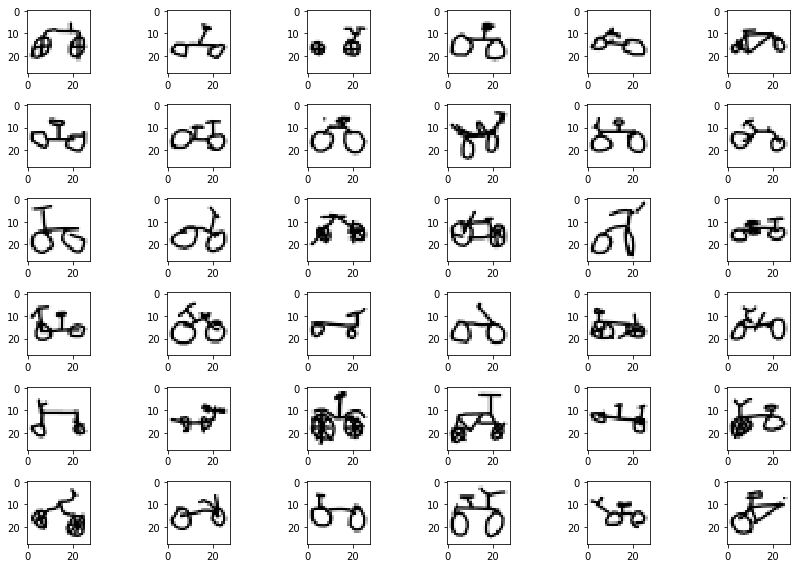

In [5]:
n_img_row = 6 
fig = plt.figure(figsize=(12,8))
for k in range(n_img_row*n_img_row):
  plt.subplot(n_img_row,n_img_row,k+1)
  plt.imshow(data[100*k].reshape(28,28), cmap='Greys')
  
plt.tight_layout()

In [0]:
# normalize data
data = data/255.0

In [7]:
# reshape data
img_w = 28
img_h = 28
img_c = 1
m = data.shape[0] # m is the number of training example
data = np.reshape(data,(m,img_w,img_h,img_c))
print("data.shape = " + str(data.shape))

data.shape = (126527, 28, 28, 1)


### Creata a model for discriminator

In [0]:
# dimension of the noise vector
np.random.seed(1)
z_dim=100

In [0]:
def discriminator_builder(depth=64,p=0.4):

    # Define inputs
    inputs = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    output = Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [10]:
discriminator = discriminator_builder()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
______

In [11]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    
    # Define inputs
    inputs = Input((z_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [13]:
generator = generator_builder()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0 

### Create adversarial network

In [0]:
def adversarial_builder():
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

In [15]:
adversarial_model = adversarial_builder()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         396961    
_________________________________________________________________
model_1 (Model)              (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


#### Functions to save and load GAN models and weights

In [0]:
# functions to save and load GAN models and weights

def save_GAN(adversarial_model,discriminator,generator):
  '''
  a function to save all models and their weights including adversarial, discriminator and generator networks
  
  '''
  directory_for_saved_models = "/gdrive/My Drive/Colab Notebooks/"
  adversarial_model.save(directory_for_saved_models+"adversarial_model.h5")
  adversarial_model.save_weights(directory_for_saved_models+"adversarial_model_weights.h5")
  discriminator.save(directory_for_saved_models+"discriminator.h5")
  discriminator.save_weights(directory_for_saved_models+"discriminator_weights.h5")
  generator.save(directory_for_saved_models+"generator.h5")
  generator.save_weights(directory_for_saved_models+"generator_weights.h5")
  
def load_GAN_weights(adversarial_model,discriminator,generator):
  directory_for_saved_models = "/gdrive/My Drive/Colab Notebooks/"
  adversarial_model.load_weights(directory_for_saved_models+"adversarial_model_weights.h5")
  discriminator.load_weights(directory_for_saved_models+"discriminator_weights.h5")
  generator.load_weights(directory_for_saved_models+"generator_weights.h5")

#### Train

In [0]:
# a function to make a model trainable or not trainable
# we need this function because in GAN sometimes we need to make the discriminator trainable and sometimes we need to just use it without being trained
def make_trainable(net,val):
  net.trainable = val
  for l in net.layers:
    l.trainable = val

In [0]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i)%1000 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='Greys')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch #1
0: [D loss: inf, acc: inf]  [A loss: inf, acc: nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


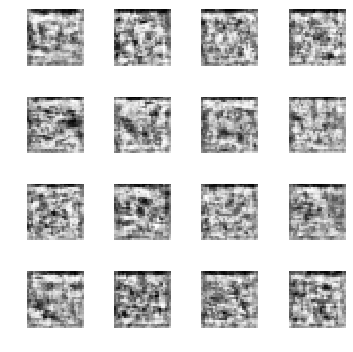

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100
200
300
400
500
600
700
800
900
1000
Epoch #1001
1000: [D loss: 0.616619, acc: 0.672891]  [A loss: 1.126879, acc: 0.130148]


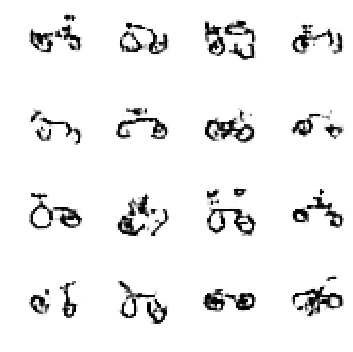

1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Epoch #2001
2000: [D loss: 0.599005, acc: 0.688559]  [A loss: 1.278611, acc: 0.119578]


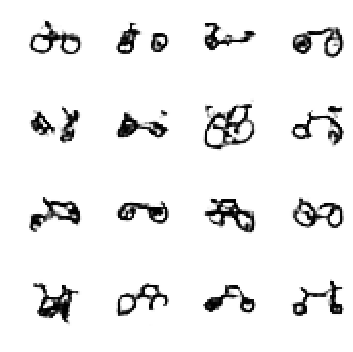

2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
Epoch #3001
3000: [D loss: 0.597206, acc: 0.694970]  [A loss: 1.453767, acc: 0.118510]


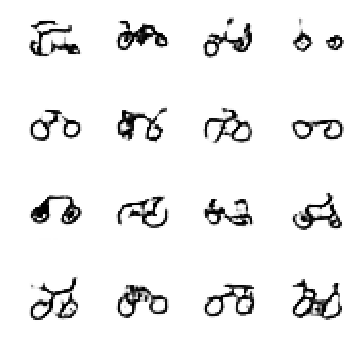

3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
Epoch #4001
4000: [D loss: 0.600771, acc: 0.698130]  [A loss: 1.637737, acc: 0.120926]


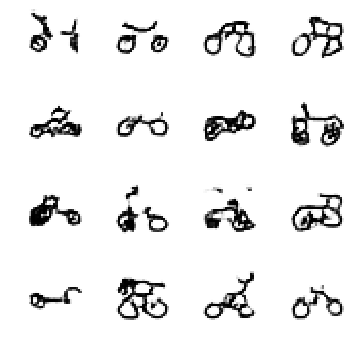

4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Epoch #5001
5000: [D loss: 0.597226, acc: 0.702706]  [A loss: 1.755058, acc: 0.119773]


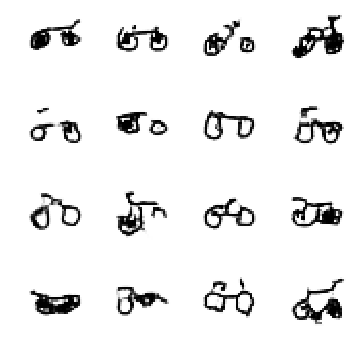

5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
Epoch #6001
6000: [D loss: 0.592499, acc: 0.707281]  [A loss: 1.844391, acc: 0.118592]


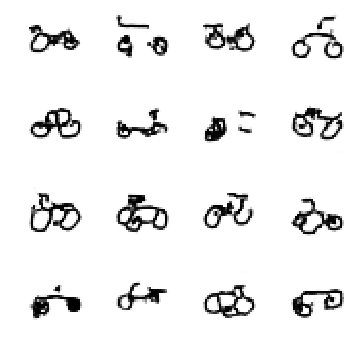

6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
Epoch #7001
7000: [D loss: 0.591361, acc: 0.710074]  [A loss: 1.910147, acc: 0.118326]


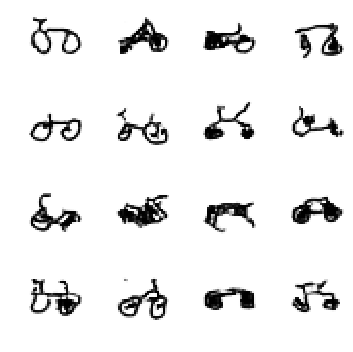

7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
Epoch #8001
8000: [D loss: 0.591736, acc: 0.711500]  [A loss: 1.940966, acc: 0.118691]


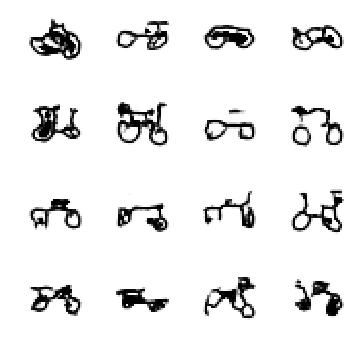

8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
Epoch #9001
9000: [D loss: 0.594153, acc: 0.709109]  [A loss: 1.915146, acc: 0.120010]


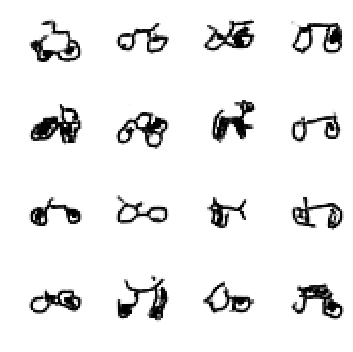

9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
Epoch #10001
10000: [D loss: 0.598159, acc: 0.704890]  [A loss: 1.852740, acc: 0.121800]


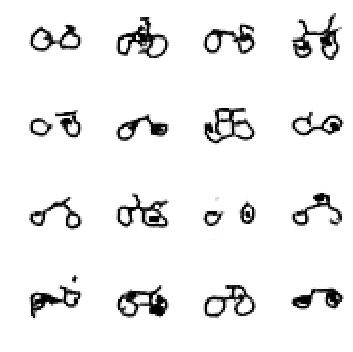

10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
Epoch #11001
11000: [D loss: 0.601616, acc: 0.701087]  [A loss: 1.793395, acc: 0.123869]


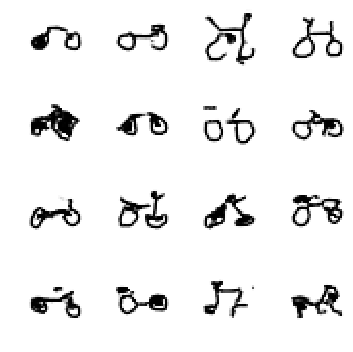

11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
Epoch #12001
12000: [D loss: 0.606557, acc: 0.696080]  [A loss: 1.723183, acc: 0.126436]


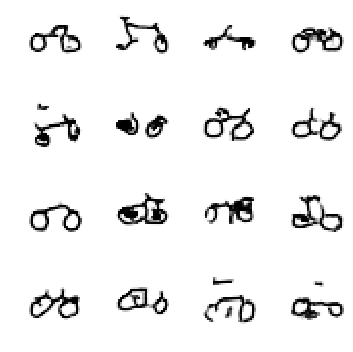

12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
Epoch #13001
13000: [D loss: 0.609866, acc: 0.692764]  [A loss: 1.661148, acc: 0.128231]


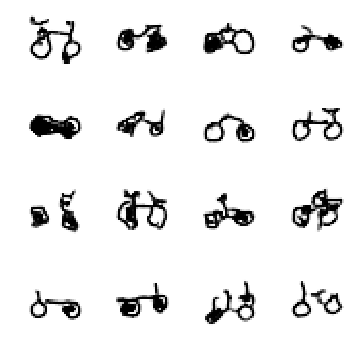

13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
Epoch #14001
14000: [D loss: 0.611914, acc: 0.690878]  [A loss: 1.609855, acc: 0.129867]


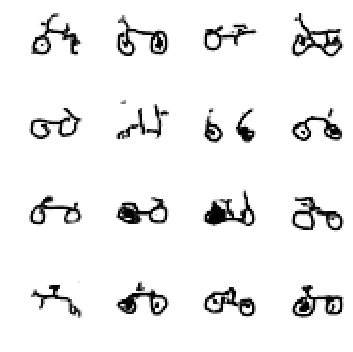

14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
Epoch #15001
15000: [D loss: 0.613755, acc: 0.689054]  [A loss: 1.566785, acc: 0.131493]


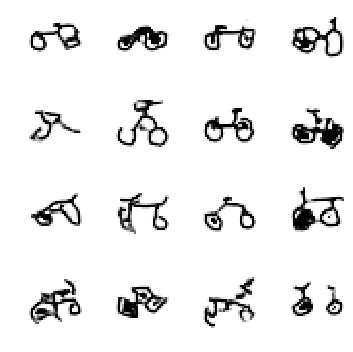

15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
Epoch #16001
16000: [D loss: 0.615744, acc: 0.687088]  [A loss: 1.530174, acc: 0.133058]


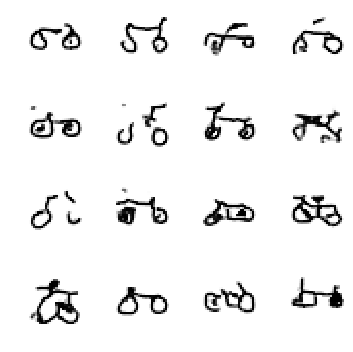

16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
Epoch #17001
17000: [D loss: 0.618273, acc: 0.684484]  [A loss: 1.497572, acc: 0.135088]


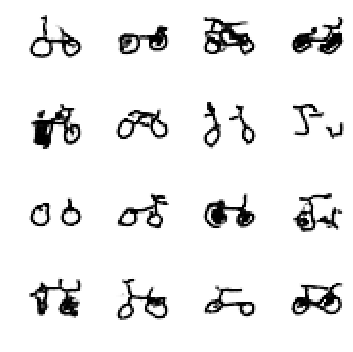

17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
Epoch #18001
18000: [D loss: 0.620852, acc: 0.681622]  [A loss: 1.468201, acc: 0.137203]


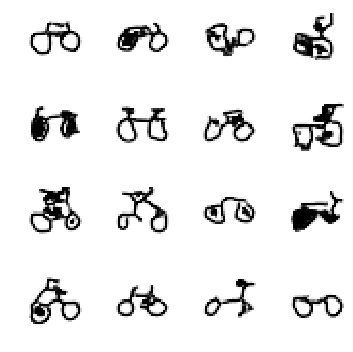

18100
18200
18300
18400
18500
18600
18700
18800
18900
19000
Epoch #19001
19000: [D loss: 0.624200, acc: 0.678234]  [A loss: 1.441105, acc: 0.139670]


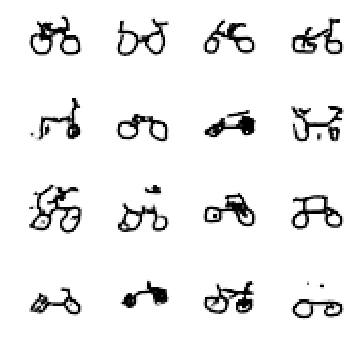

19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
Epoch #20001
20000: [D loss: 0.626997, acc: 0.674638]  [A loss: 1.415553, acc: 0.142245]


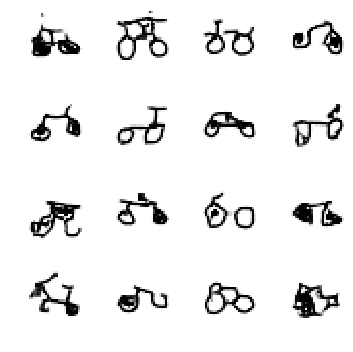

20100
20200
20300
20400
20500
20600
20700
20800
20900
21000
Epoch #21001
21000: [D loss: 0.629992, acc: 0.670441]  [A loss: 1.391306, acc: 0.145157]


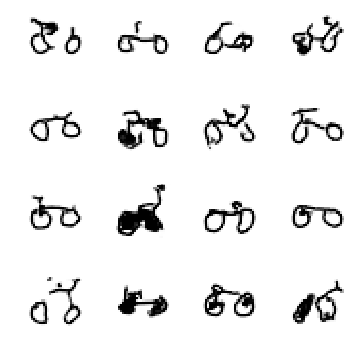

21100
21200
21300
21400
21500
21600
21700
21800
21900
22000
Epoch #22001
22000: [D loss: 0.633892, acc: 0.664418]  [A loss: 1.367448, acc: 0.148261]


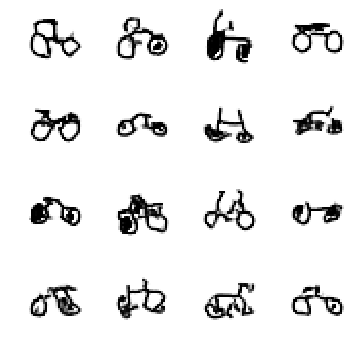

22100
22200
22300
22400
22500
22600
22700
22800
22900
23000
Epoch #23001
23000: [D loss: 0.637453, acc: 0.658584]  [A loss: 1.344818, acc: 0.151202]


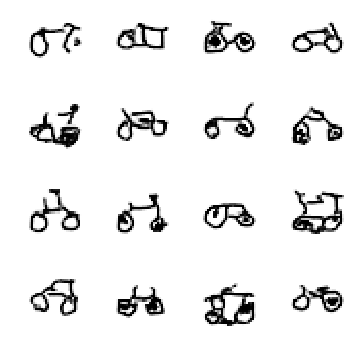

23100
23200
23300
23400
23500
23600
23700
23800
23900
24000
Epoch #24001
24000: [D loss: 0.640346, acc: 0.653981]  [A loss: 1.324079, acc: 0.153876]


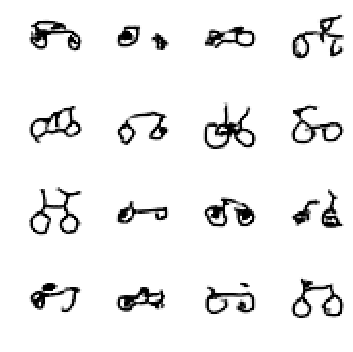

24100
24200
24300
24400
24500
24600
24700
24800
24900
25000
Epoch #25001
25000: [D loss: 0.642928, acc: 0.649927]  [A loss: 1.304897, acc: 0.156521]


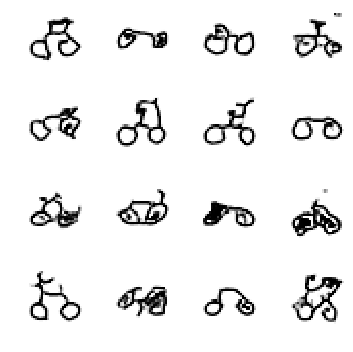

25100
25200
25300
25400
25500
25600
25700
25800
25900
26000
Epoch #26001
26000: [D loss: 0.645414, acc: 0.645726]  [A loss: 1.286880, acc: 0.158959]


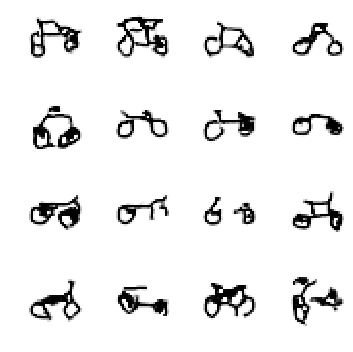

26100
26200
26300
26400
26500
26600
26700
26800
26900
27000
Epoch #27001
27000: [D loss: 0.647956, acc: 0.640831]  [A loss: 1.269199, acc: 0.161225]


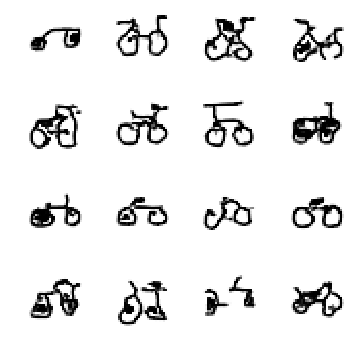

27100
27200
27300
27400
27500
27600
27700
27800
27900
28000
Epoch #28001
28000: [D loss: 0.650046, acc: 0.636537]  [A loss: 1.251785, acc: 0.164051]


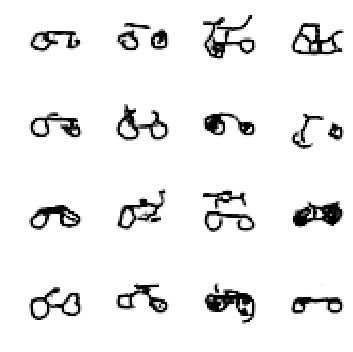

28100
28200
28300
28400
28500
28600
28700
28800
28900
29000
Epoch #29001
29000: [D loss: 0.652007, acc: 0.632435]  [A loss: 1.235349, acc: 0.166877]


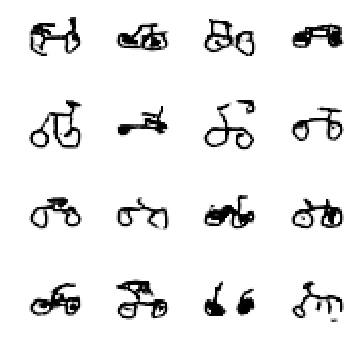

29100
29200
29300
29400
29500
29600
29700
29800
29900
30000
Epoch #30001
30000: [D loss: 0.653700, acc: 0.629022]  [A loss: 1.220354, acc: 0.168907]


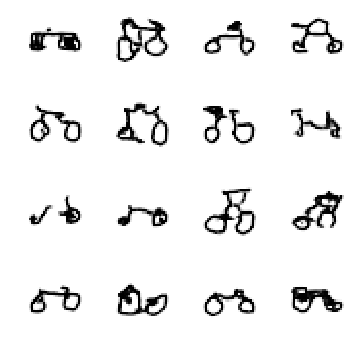

30100
30200
30300
30400
30500
30600
30700
30800
30900
31000
Epoch #31001
31000: [D loss: 0.655175, acc: 0.626211]  [A loss: 1.206449, acc: 0.170957]


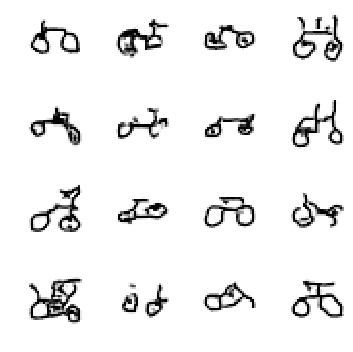

31100
31200
31300
31400
31500
31600
31700
31800
31900
32000
Epoch #32001
32000: [D loss: 0.656647, acc: 0.623436]  [A loss: 1.193400, acc: 0.173134]


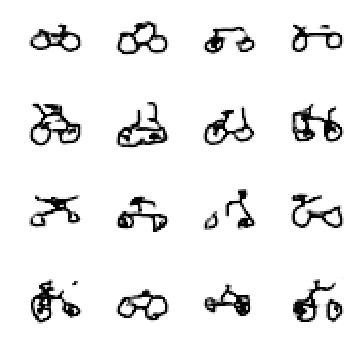

32100
32200
32300
32400
32500
32600
32700
32800
32900
33000
Epoch #33001
33000: [D loss: 0.657983, acc: 0.620833]  [A loss: 1.181144, acc: 0.175230]


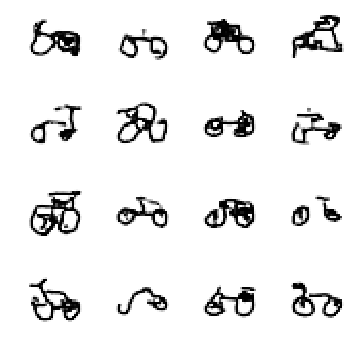

33100
33200
33300
33400
33500
33600
33700
33800
33900
34000
Epoch #34001
34000: [D loss: 0.659117, acc: 0.618750]  [A loss: 1.169824, acc: 0.177221]


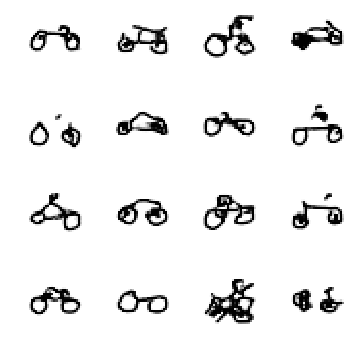

34100
34200
34300
34400
34500
34600
34700
34800
34900
35000
Epoch #35001
35000: [D loss: 0.660200, acc: 0.616861]  [A loss: 1.159309, acc: 0.179254]


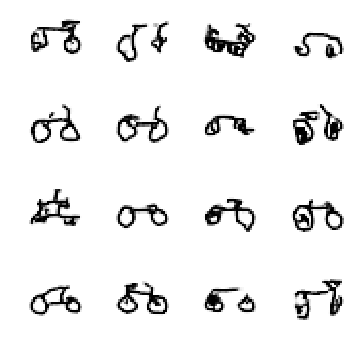

35100
35200
35300
35400
35500
35600
35700
35800
35900
36000
Epoch #36001
36000: [D loss: 0.661162, acc: 0.615296]  [A loss: 1.149655, acc: 0.181231]


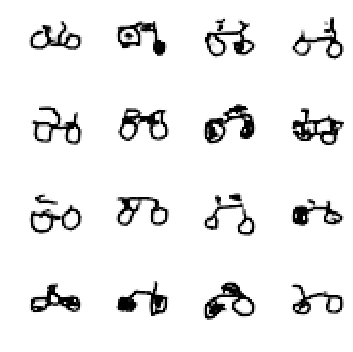

36100
36200
36300
36400
36500
36600
36700
36800
36900
37000
Epoch #37001
37000: [D loss: 0.662082, acc: 0.613850]  [A loss: 1.140806, acc: 0.182969]


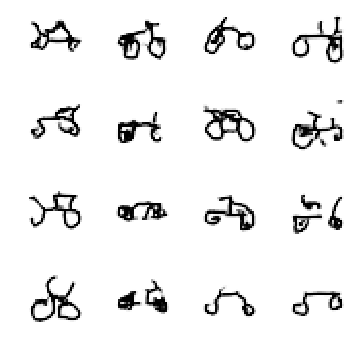

37100
37200
37300
37400
37500
37600
37700
37800
37900
38000
Epoch #38001
38000: [D loss: 0.662976, acc: 0.612479]  [A loss: 1.132739, acc: 0.184448]


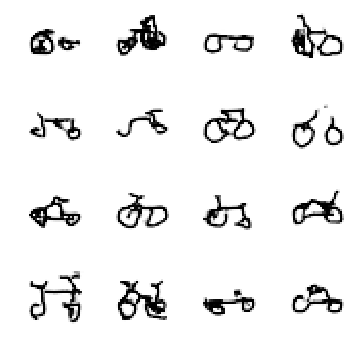

38100
38200
38300
38400
38500
38600
38700
38800
38900
39000
Epoch #39001
39000: [D loss: 0.664006, acc: 0.610792]  [A loss: 1.124862, acc: 0.186148]


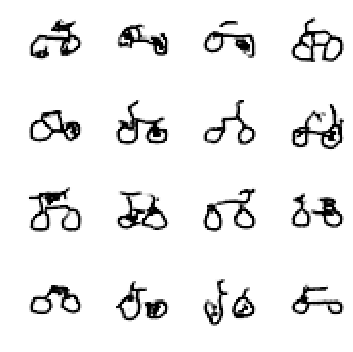

39100
39200
39300
39400
39500
39600
39700
39800
39900
40000
Epoch #40001
40000: [D loss: 0.665059, acc: 0.609050]  [A loss: 1.117480, acc: 0.187670]


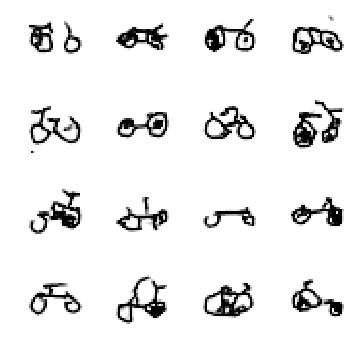

40100
40200
40300
40400
40500
40600
40700
40800
40900
41000
Epoch #41001
41000: [D loss: 0.666041, acc: 0.607522]  [A loss: 1.110619, acc: 0.189158]


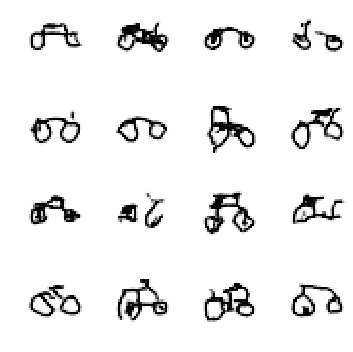

41100
41200
41300
41400
41500
41600
41700
41800
41900
42000
Epoch #42001
42000: [D loss: 0.666972, acc: 0.606236]  [A loss: 1.104359, acc: 0.190666]


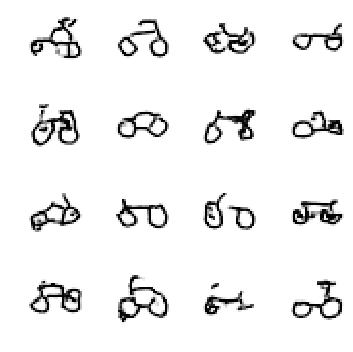

42100
42200
42300
42400
42500
42600
42700
42800
42900
43000
Epoch #43001
43000: [D loss: 0.667899, acc: 0.604911]  [A loss: 1.098573, acc: 0.191983]


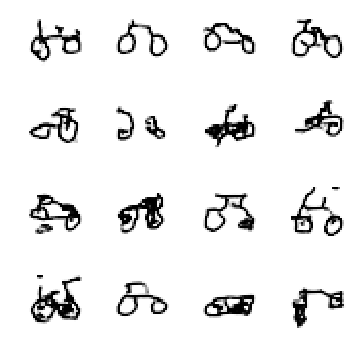

43100
43200
43300
43400
43500
43600
43700
43800
43900
44000
Epoch #44001
44000: [D loss: 0.668943, acc: 0.603411]  [A loss: 1.092723, acc: 0.193551]


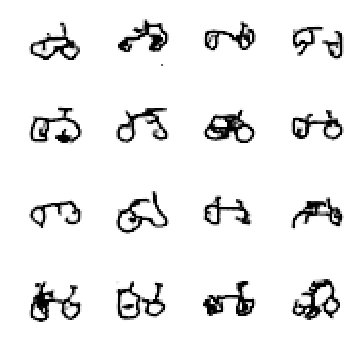

44100
44200
44300
44400
44500
44600
44700
44800
44900
45000
Epoch #45001
45000: [D loss: 0.669992, acc: 0.601902]  [A loss: 1.087218, acc: 0.194904]


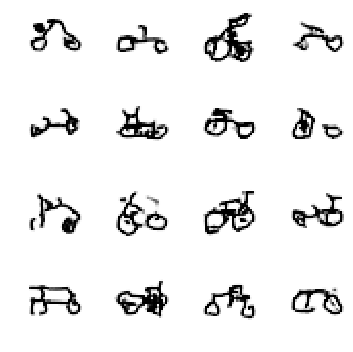

45100
45200
45300
45400
45500
45600
45700
45800
45900
46000
Epoch #46001
46000: [D loss: 0.671087, acc: 0.600229]  [A loss: 1.081696, acc: 0.196395]


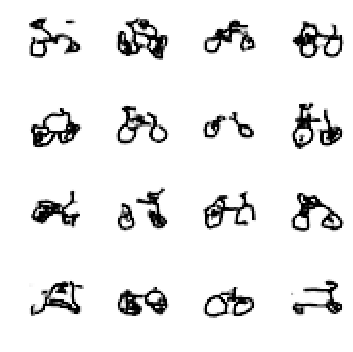

46100
46200
46300
46400
46500
46600
46700
46800
46900
47000
Epoch #47001
47000: [D loss: 0.672242, acc: 0.598494]  [A loss: 1.076127, acc: 0.198109]


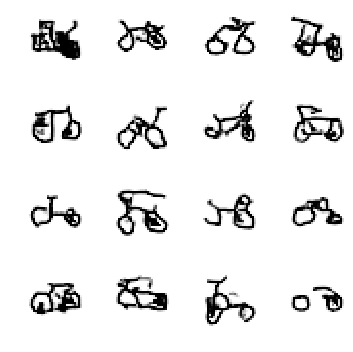

47100
47200
47300
47400
47500
47600
47700
47800
47900
48000
Epoch #48001
48000: [D loss: 0.673361, acc: 0.596736]  [A loss: 1.070654, acc: 0.200119]


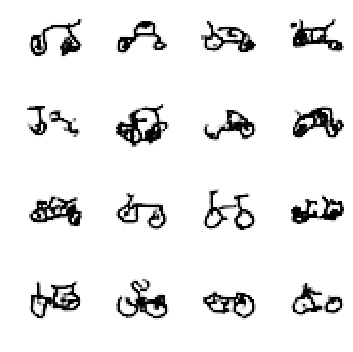

48100
48200
48300
48400
48500
48600
48700
48800
48900
49000
Epoch #49001
49000: [D loss: 0.674391, acc: 0.594985]  [A loss: 1.065348, acc: 0.201926]


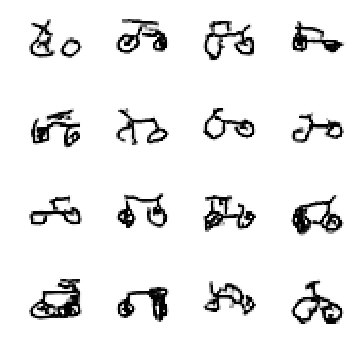

49100
49200
49300
49400
49500
49600
49700
49800
49900
50000
Epoch #50001
50000: [D loss: 0.675347, acc: 0.593318]  [A loss: 1.060241, acc: 0.203660]


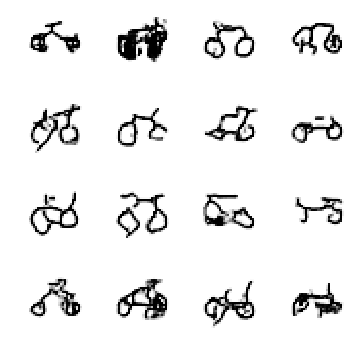

50100
50200
50300
50400
50500
50600
50700
50800
50900
51000
Epoch #51001
51000: [D loss: 0.676314, acc: 0.591661]  [A loss: 1.055169, acc: 0.205474]


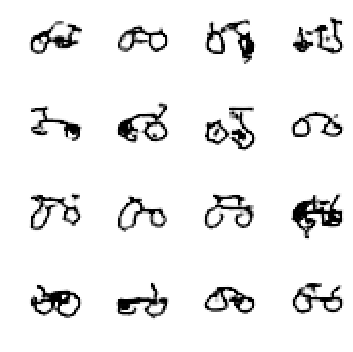

51100
51200
51300
51400
51500
51600
51700
51800
51900
52000
Epoch #52001
52000: [D loss: 0.677185, acc: 0.590073]  [A loss: 1.050409, acc: 0.207136]


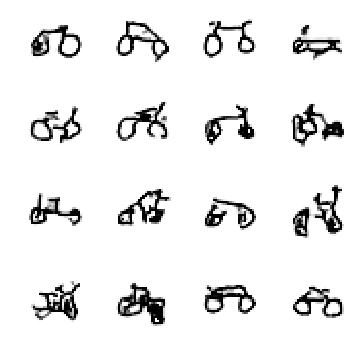

52100
52200
52300
52400
52500
52600
52700
52800
52900
53000
Epoch #53001
53000: [D loss: 0.678026, acc: 0.588527]  [A loss: 1.045837, acc: 0.208666]


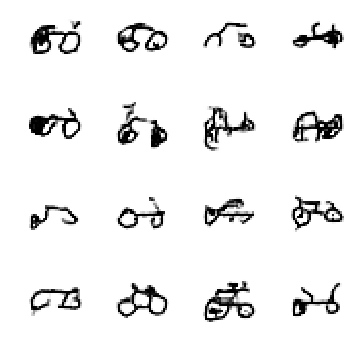

53100
53200
53300
53400
53500
53600
53700
53800
53900
54000
Epoch #54001
54000: [D loss: 0.678792, acc: 0.587002]  [A loss: 1.041330, acc: 0.210228]


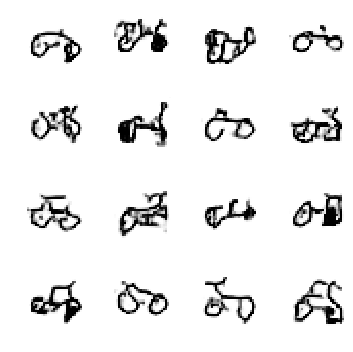

54100
54200
54300
54400
54500
54600
54700
54800
54900
55000
Epoch #55001
55000: [D loss: 0.679544, acc: 0.585482]  [A loss: 1.036908, acc: 0.211832]


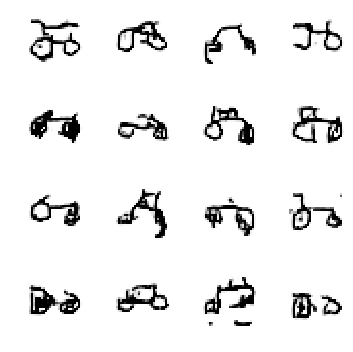

55100
55200
55300
55400
55500
55600
55700
55800
55900
56000
Epoch #56001
56000: [D loss: 0.680276, acc: 0.583982]  [A loss: 1.032635, acc: 0.213415]


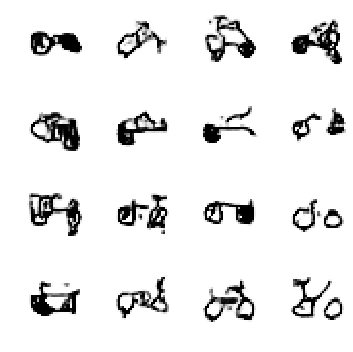

56100
56200
56300
56400
56500
56600
56700
56800
56900
57000
Epoch #57001
57000: [D loss: 0.681017, acc: 0.582538]  [A loss: 1.028367, acc: 0.215258]


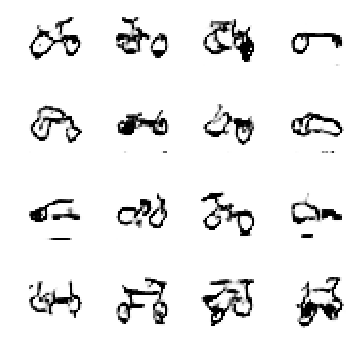

57100
57200
57300
57400
57500
57600
57700
57800
57900
58000
Epoch #58001
58000: [D loss: 0.681585, acc: 0.581101]  [A loss: 1.023888, acc: 0.217356]


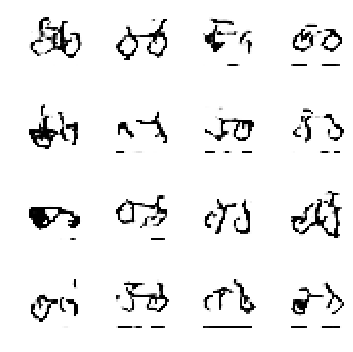

58100
58200
58300
58400
58500
58600
58700
58800
58900
59000
Epoch #59001
59000: [D loss: 0.682081, acc: 0.579729]  [A loss: 1.019459, acc: 0.219284]


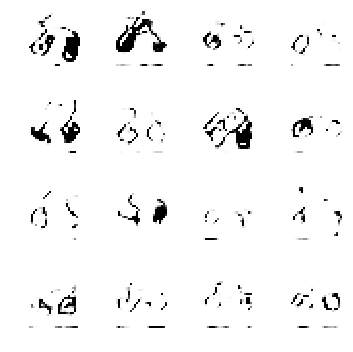

59100
59200
59300
59400
59500
59600
59700
59800
59900
60000
Epoch #60001
60000: [D loss: 0.682478, acc: 0.578411]  [A loss: 1.015188, acc: 0.220853]


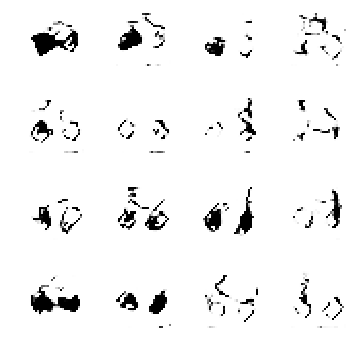

60100
60200
60300
60400
60500
60600
60700
60800
60900
61000
Epoch #61001
61000: [D loss: 0.682774, acc: 0.577131]  [A loss: 1.010773, acc: 0.222465]


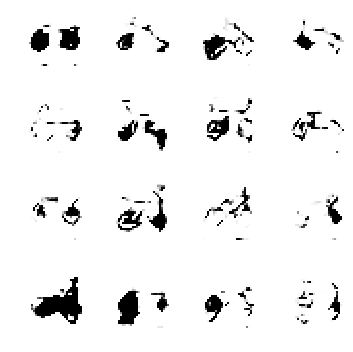

61100
61200
61300
61400
61500
61600
61700
61800
61900
62000
Epoch #62001
62000: [D loss: 0.683023, acc: 0.575908]  [A loss: 1.006348, acc: 0.224237]


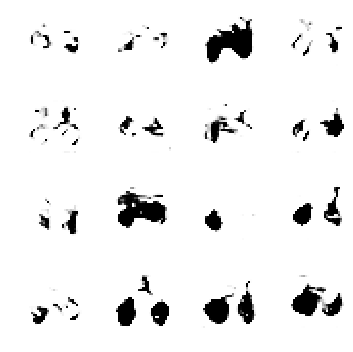

62100
62200
62300
62400
62500
62600
62700
62800
62900
63000
Epoch #63001
63000: [D loss: 0.683241, acc: 0.574679]  [A loss: 1.001804, acc: 0.226615]


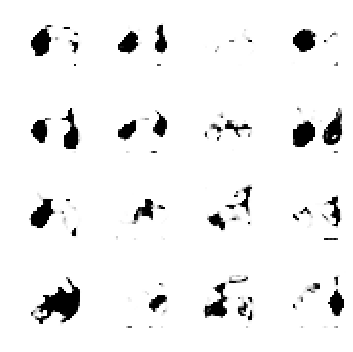

63100
63200
63300
63400
63500
63600
63700
63800
63900
64000
Epoch #64001
64000: [D loss: 0.683445, acc: 0.573506]  [A loss: 0.997396, acc: 0.228834]


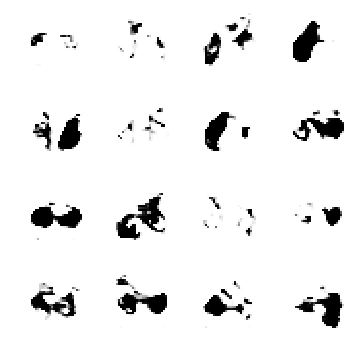

64100
64200
64300
64400
64500
64600
64700
64800
64900
65000
Epoch #65001
65000: [D loss: 0.683629, acc: 0.572401]  [A loss: 0.993089, acc: 0.230847]


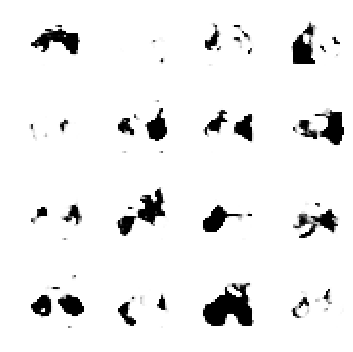

65100
65200
65300
65400
65500
65600
65700
65800
65900
66000
Epoch #66001
66000: [D loss: 0.683806, acc: 0.571298]  [A loss: 0.988892, acc: 0.232786]


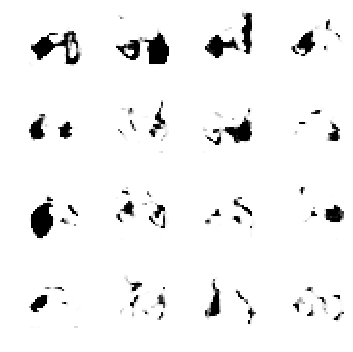

66100
66200
66300
66400
66500
66600
66700
66800
66900
67000
Epoch #67001
67000: [D loss: 0.683974, acc: 0.570233]  [A loss: 0.984840, acc: 0.234560]


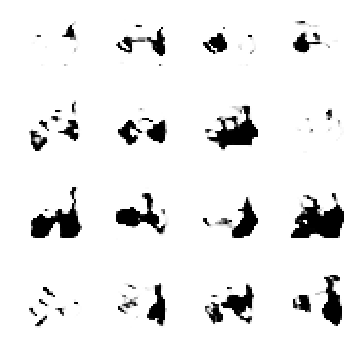

67100
67200
67300
67400
67500
67600
67700
67800
67900
68000
Epoch #68001
68000: [D loss: 0.684143, acc: 0.569204]  [A loss: 0.980960, acc: 0.236049]


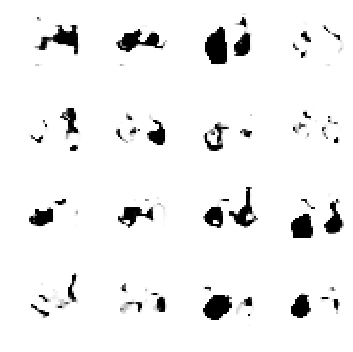

68100
68200
68300
68400
68500
68600
68700
68800
68900
69000
Epoch #69001
69000: [D loss: 0.684308, acc: 0.568201]  [A loss: 0.977225, acc: 0.237414]


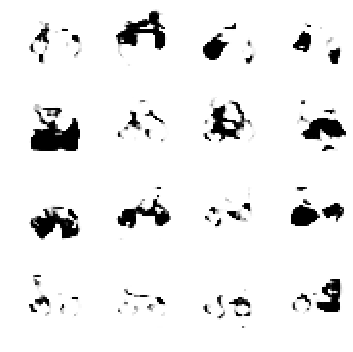

69100
69200
69300
69400
69500
69600
69700
69800
69900
70000
Epoch #70001
70000: [D loss: 0.684472, acc: 0.567218]  [A loss: 0.973609, acc: 0.238716]


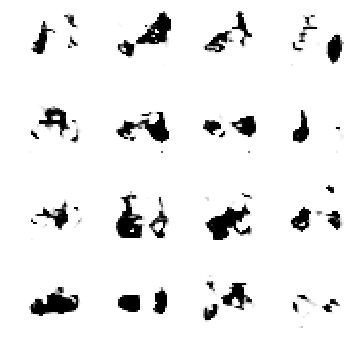

70100
70200
70300
70400
70500
70600
70700
70800
70900
71000
Epoch #71001
71000: [D loss: 0.684632, acc: 0.566268]  [A loss: 0.970108, acc: 0.239996]


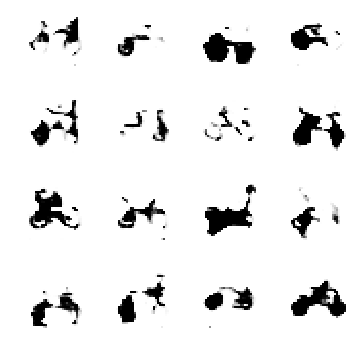

71100
71200
71300
71400
71500
71600
71700
71800
71900
72000
Epoch #72001
72000: [D loss: 0.684787, acc: 0.565353]  [A loss: 0.966723, acc: 0.241268]


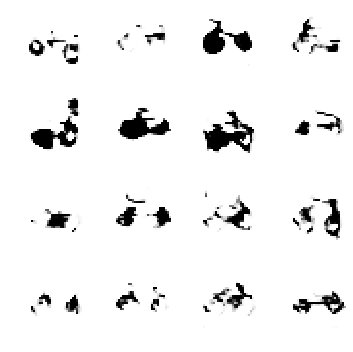

72100
72200
72300
72400
72500
72600
72700
72800
72900
73000
Epoch #73001
73000: [D loss: 0.684942, acc: 0.564452]  [A loss: 0.963427, acc: 0.242527]


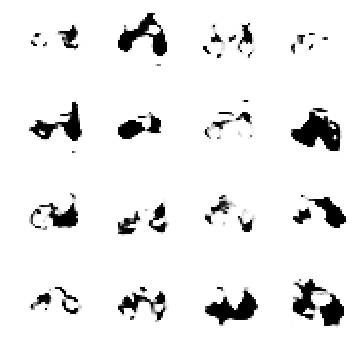

73100
73200
73300
73400
73500
73600
73700
73800
73900
74000
Epoch #74001
74000: [D loss: 0.685096, acc: 0.563553]  [A loss: 0.960227, acc: 0.243757]


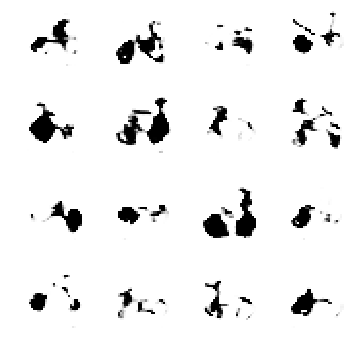

74100
74200
74300
74400
74500
74600
74700
74800
74900
75000
Epoch #75001
75000: [D loss: 0.685240, acc: 0.562724]  [A loss: 0.957078, acc: 0.245026]


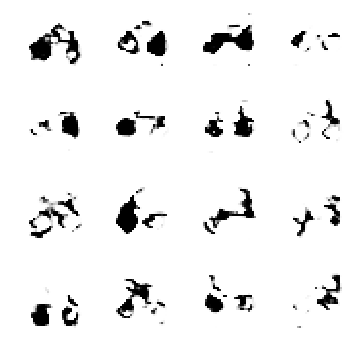

75100
75200
75300
75400
75500
75600
75700
75800
75900
76000
Epoch #76001
76000: [D loss: 0.685382, acc: 0.561900]  [A loss: 0.954009, acc: 0.246266]


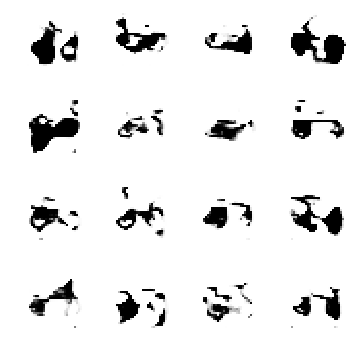

76100
76200
76300
76400
76500
76600
76700
76800
76900
77000
Epoch #77001
77000: [D loss: 0.685526, acc: 0.561087]  [A loss: 0.951039, acc: 0.247435]


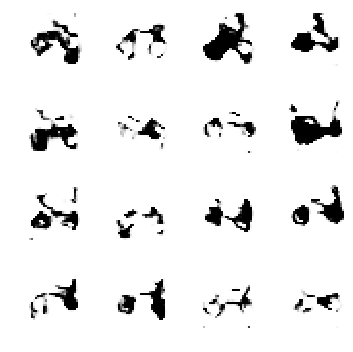

77100
77200
77300
77400
77500
77600
77700
77800
77900
78000
Epoch #78001
78000: [D loss: 0.685668, acc: 0.560304]  [A loss: 0.948155, acc: 0.248535]


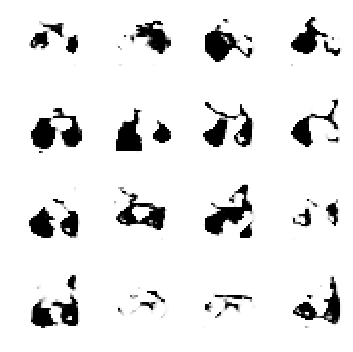

78100
78200
78300
78400
78500
78600
78700
78800
78900
79000
Epoch #79001
79000: [D loss: 0.685804, acc: 0.559556]  [A loss: 0.945331, acc: 0.249647]


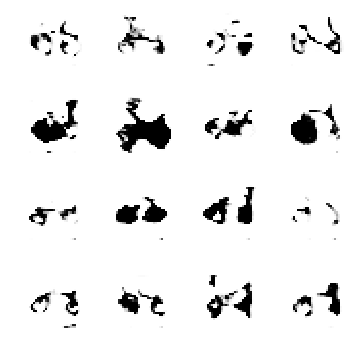

79100
79200
79300
79400
79500
79600
79700
79800
79900
80000
Epoch #80001
80000: [D loss: 0.685944, acc: 0.558808]  [A loss: 0.942589, acc: 0.250737]


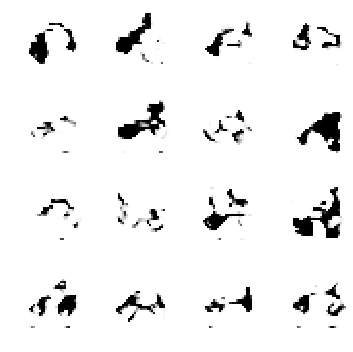

80100
80200
80300
80400
80500
80600
80700
80800
80900
81000
Epoch #81001
81000: [D loss: 0.686080, acc: 0.558084]  [A loss: 0.939920, acc: 0.251736]


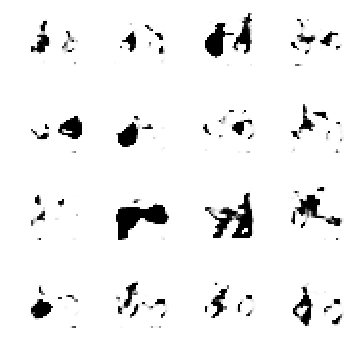

81100
81200
81300
81400
81500
81600
81700
81800
81900
82000
Epoch #82001
82000: [D loss: 0.686210, acc: 0.557384]  [A loss: 0.937299, acc: 0.252787]


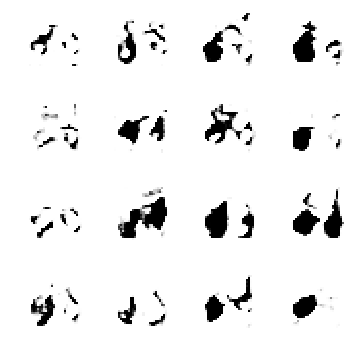

82100
82200
82300
82400
82500
82600
82700
82800
82900
83000
Epoch #83001
83000: [D loss: 0.686335, acc: 0.556707]  [A loss: 0.934737, acc: 0.253827]


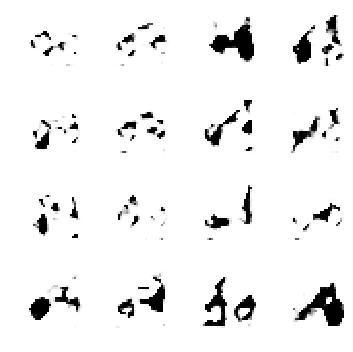

83100
83200
83300
83400
83500
83600
83700
83800
83900
84000
Epoch #84001
84000: [D loss: 0.686461, acc: 0.556023]  [A loss: 0.932233, acc: 0.254875]


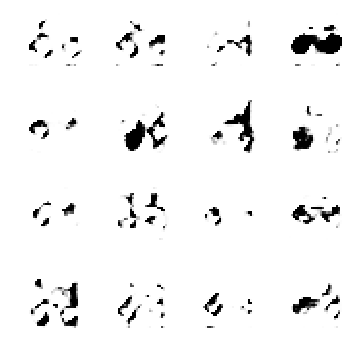

84100
84200
84300
84400
84500
84600
84700
84800
84900
85000
Epoch #85001
85000: [D loss: 0.686588, acc: 0.555365]  [A loss: 0.929793, acc: 0.255935]


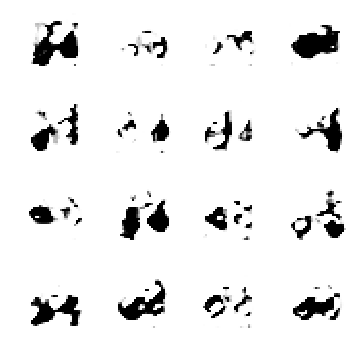

85100
85200
85300
85400
85500
85600
85700
85800
85900
86000
Epoch #86001
86000: [D loss: 0.686716, acc: 0.554724]  [A loss: 0.927405, acc: 0.256987]


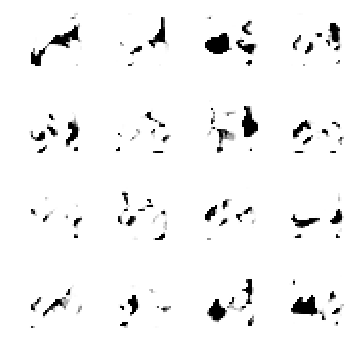

86100
86200
86300
86400
86500
86600
86700
86800
86900
87000
Epoch #87001
87000: [D loss: 0.686842, acc: 0.554110]  [A loss: 0.925073, acc: 0.258052]


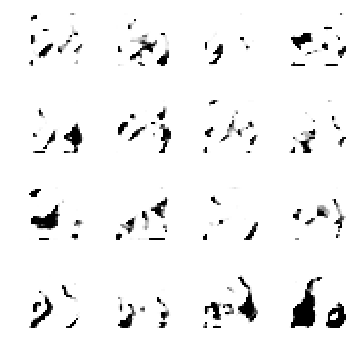

87100
87200
87300
87400
87500
87600
87700
87800
87900
88000
Epoch #88001
88000: [D loss: 0.686977, acc: 0.553501]  [A loss: 0.922791, acc: 0.259112]


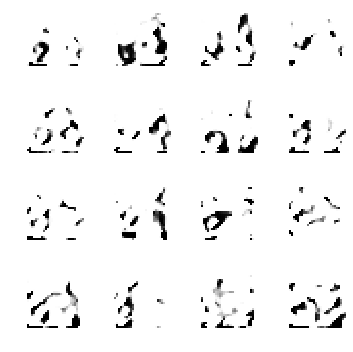

88100
88200
88300
88400
88500
88600
88700
88800
88900
89000
Epoch #89001
89000: [D loss: 0.687098, acc: 0.552906]  [A loss: 0.920571, acc: 0.260161]


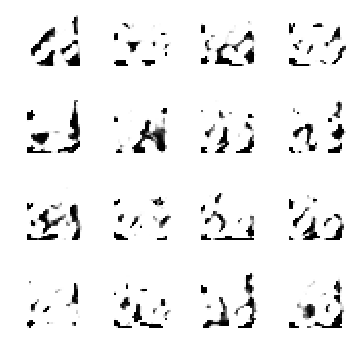

89100
89200
89300
89400
89500
89600
89700
89800
89900
90000
Epoch #90001
90000: [D loss: 0.687218, acc: 0.552316]  [A loss: 0.918390, acc: 0.261222]


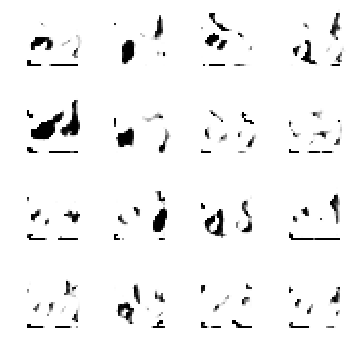

90100
90200
90300
90400
90500
90600
90700
90800
90900
91000
Epoch #91001
91000: [D loss: 0.687331, acc: 0.551744]  [A loss: 0.916257, acc: 0.262202]


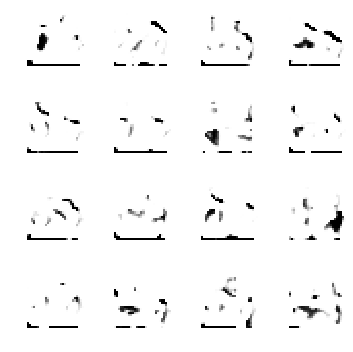

91100
91200
91300
91400
91500
91600
91700
91800
91900
92000
Epoch #92001
92000: [D loss: 0.687437, acc: 0.551192]  [A loss: 0.914155, acc: 0.263184]


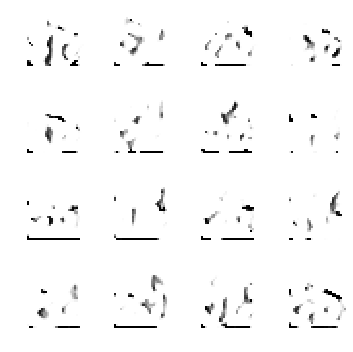

92100
92200
92300
92400
92500
92600
92700
92800
92900
93000
Epoch #93001
93000: [D loss: 0.687544, acc: 0.550641]  [A loss: 0.912101, acc: 0.264147]


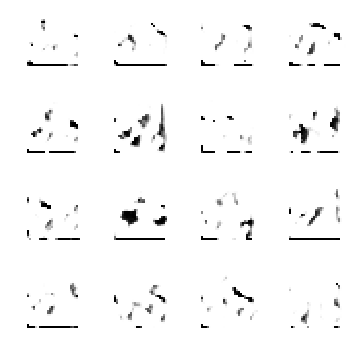

93100
93200
93300
93400
93500
93600
93700
93800
93900
94000
Epoch #94001
94000: [D loss: 0.687645, acc: 0.550091]  [A loss: 0.910087, acc: 0.265089]


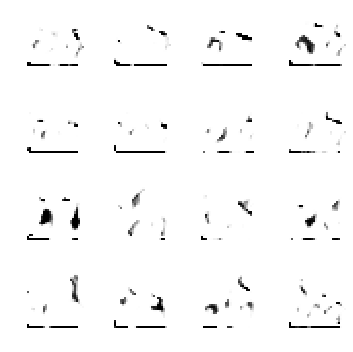

94100
94200
94300
94400
94500
94600
94700
94800
94900
95000
Epoch #95001
95000: [D loss: 0.687744, acc: 0.549564]  [A loss: 0.908111, acc: 0.266001]


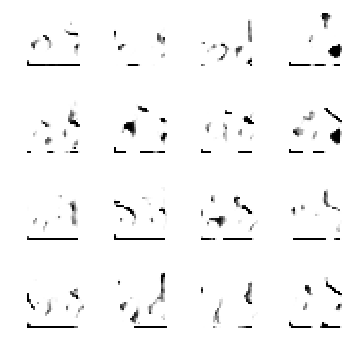

95100
95200
95300
95400
95500
95600
95700
95800
95900
96000
Epoch #96001
96000: [D loss: 0.687836, acc: 0.549056]  [A loss: 0.906162, acc: 0.266969]


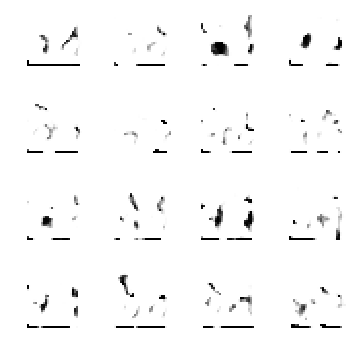

96100
96200
96300
96400
96500
96600
96700
96800
96900
97000
Epoch #97001
97000: [D loss: 0.687926, acc: 0.548554]  [A loss: 0.904249, acc: 0.267931]


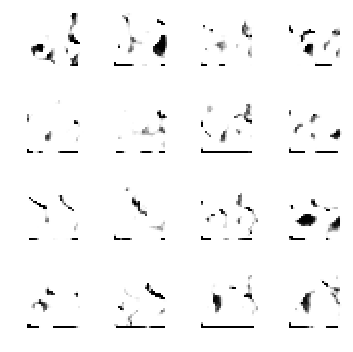

97100
97200
97300
97400
97500
97600
97700
97800
97900
98000
Epoch #98001
98000: [D loss: 0.688012, acc: 0.548042]  [A loss: 0.902368, acc: 0.268906]


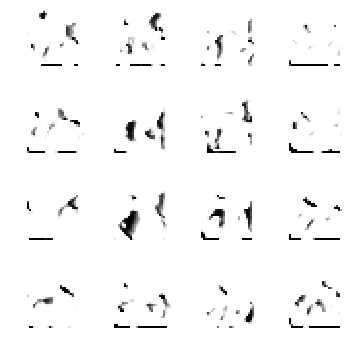

98100
98200
98300
98400
98500
98600
98700
98800
98900
99000
Epoch #99001
99000: [D loss: 0.688094, acc: 0.547566]  [A loss: 0.900522, acc: 0.269840]


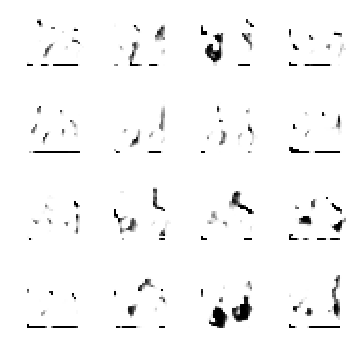

99100
99200
99300
99400
99500
99600
99700
99800
99900


In [0]:
# please do not run this box if you have run this box one time before. Just go to the next box and load the model and run that.
# we have this part in notebook for education purposes to see how the GAN is gradually imporoving in generating bicycles
a_metrics_complete, d_metrics_complete = train(epochs=100000, batch=128)

#### Some Observation and Puzzles about GAN
Training a GAN can be puzzling when for ther first time we look at accuracy, loss and generated images. The first image is completely random images. In very early epochs(1000) we see some features of a bicycle in images, however the accuracy of adversarial network (generator) is very low. 

In addition, as we train the network more, we expect to see the accuracy of the discriminator to decrease, however the opposite happens! The reason is that the discriminator itself is being trained and it's got better at discriminating fake images from real images.

After some more training we can see that discriminator losses its ability to discriminate fake images from real ones. It means that, now, the discriminator is trained up to its full potential, and from now  on it is the adversarial or generator network which is getting better and better in generating fake images. A better fake image means a fake image which is not distinguishable from real images by both the discriminator and also by us (humans).

Another observation, is that as we train more (epochs > 60000) the accuracy of the discriminator increases however the prodcued images don't look like a bicycle. Thus, we should be careful about the meaning of metrics and what we expect from the GAN network. Although the discriminator cannot tell the fake images is not a bicycle, we (humans) can!

By all these observation we train the model for `batch_size = 128` and `epochs = 50000`. The produced images are in below.

#### Re-train for optimized number of epochs
we see that if number of epochs = 50000 the generated images look like hand-drawing of bicycles. Thus we have trained the model from the begining and saved the weights after 50000 epochs. In below we see the loss and accuracy curves after 25000 epochs.

0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch #1
0: [D loss: inf, acc: inf]  [A loss: inf, acc: nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


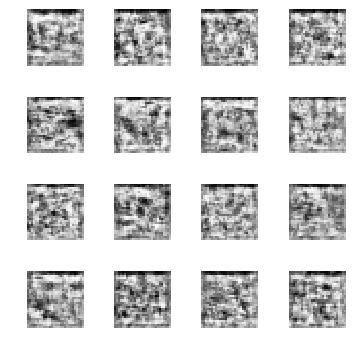

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100
200
300
400
500
600
700
800
900
1000
Epoch #1001
1000: [D loss: 0.576969, acc: 0.709363]  [A loss: 1.425859, acc: 0.090000]


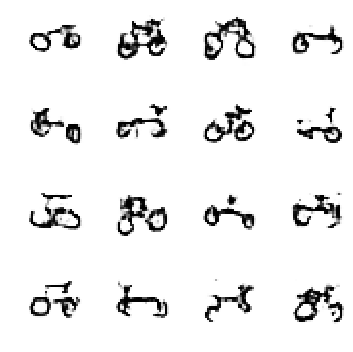

1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Epoch #2001
2000: [D loss: 0.574074, acc: 0.712426]  [A loss: 1.488647, acc: 0.098145]


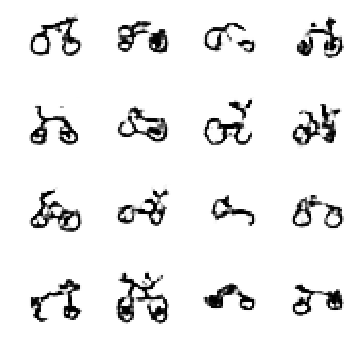

2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
Epoch #3001
3000: [D loss: 0.572037, acc: 0.716728]  [A loss: 1.646008, acc: 0.103021]


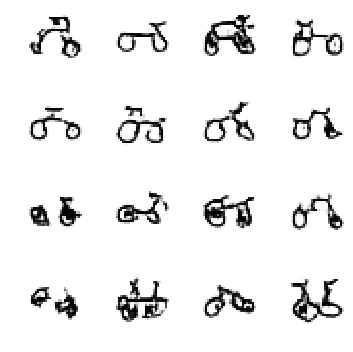

3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
Epoch #4001
4000: [D loss: 0.575337, acc: 0.717479]  [A loss: 1.740750, acc: 0.106549]


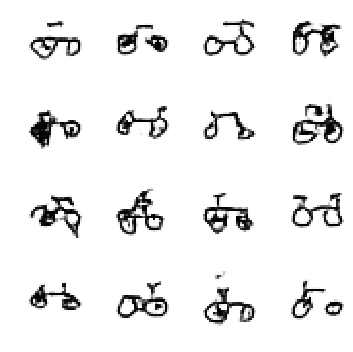

4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Epoch #5001
5000: [D loss: 0.576855, acc: 0.717066]  [A loss: 1.774085, acc: 0.109661]


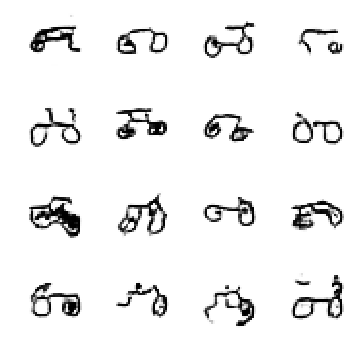

5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
Epoch #6001
6000: [D loss: 0.579030, acc: 0.715960]  [A loss: 1.758111, acc: 0.111275]


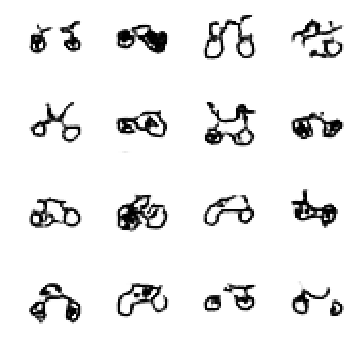

6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
Epoch #7001
7000: [D loss: 0.581437, acc: 0.714151]  [A loss: 1.721320, acc: 0.112503]


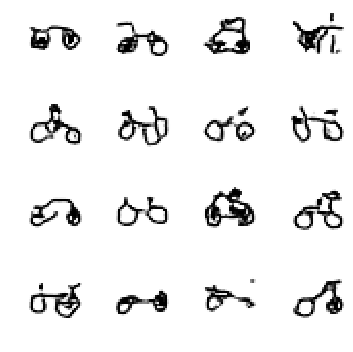

7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
Epoch #8001
8000: [D loss: 0.585525, acc: 0.710765]  [A loss: 1.667976, acc: 0.113167]


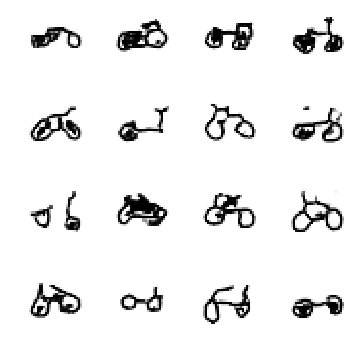

8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
Epoch #9001
9000: [D loss: 0.591041, acc: 0.706315]  [A loss: 1.594355, acc: 0.115780]


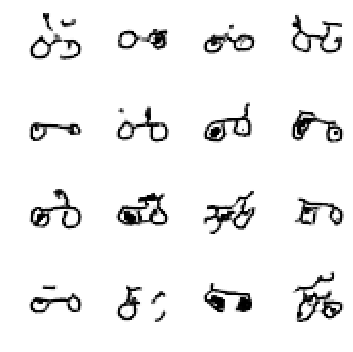

9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
Epoch #10001
10000: [D loss: 0.595310, acc: 0.703014]  [A loss: 1.529021, acc: 0.118216]


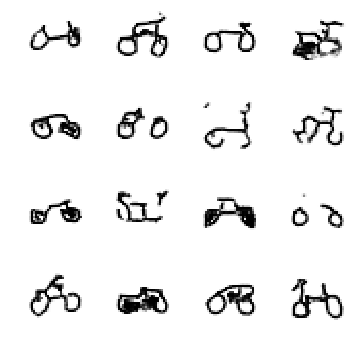

10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
Epoch #11001
11000: [D loss: 0.600081, acc: 0.698987]  [A loss: 1.475751, acc: 0.119790]


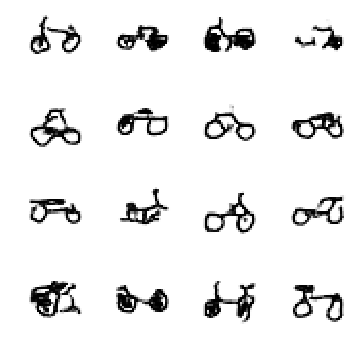

11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
Epoch #12001
12000: [D loss: 0.604516, acc: 0.694991]  [A loss: 1.432661, acc: 0.121464]


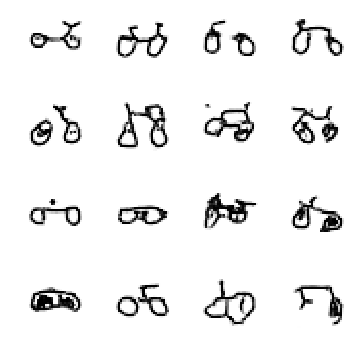

12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
Epoch #13001
13000: [D loss: 0.607916, acc: 0.691811]  [A loss: 1.396473, acc: 0.123474]


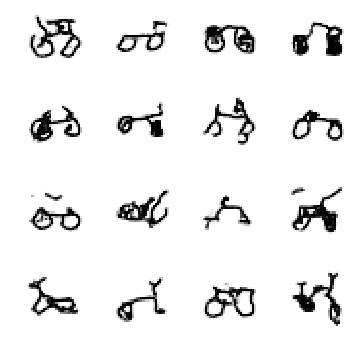

13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
Epoch #14001
14000: [D loss: 0.611036, acc: 0.688679]  [A loss: 1.366135, acc: 0.125424]


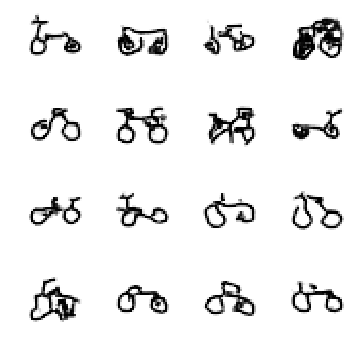

14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
Epoch #15001
15000: [D loss: 0.613869, acc: 0.685830]  [A loss: 1.340206, acc: 0.127594]


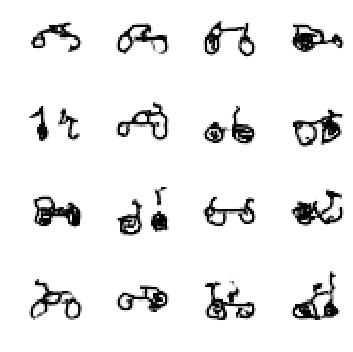

15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
Epoch #16001
16000: [D loss: 0.616913, acc: 0.682530]  [A loss: 1.316751, acc: 0.130308]


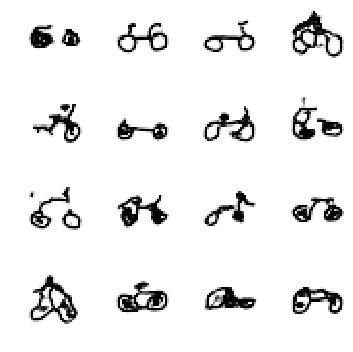

16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
Epoch #17001
17000: [D loss: 0.620270, acc: 0.678790]  [A loss: 1.295520, acc: 0.132984]


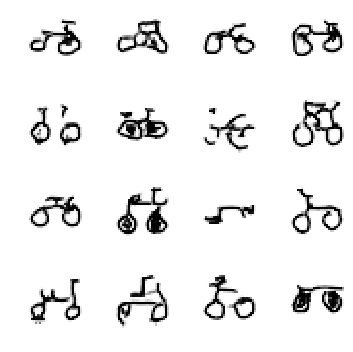

17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
Epoch #18001
18000: [D loss: 0.623987, acc: 0.674535]  [A loss: 1.276228, acc: 0.135266]


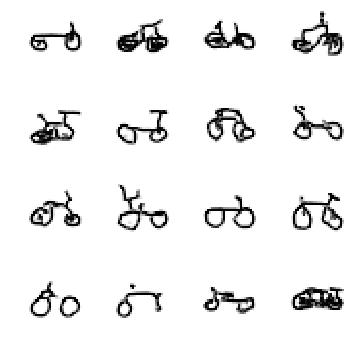

18100
18200
18300
18400
18500
18600
18700
18800
18900
19000
Epoch #19001
19000: [D loss: 0.627486, acc: 0.670312]  [A loss: 1.258268, acc: 0.137512]


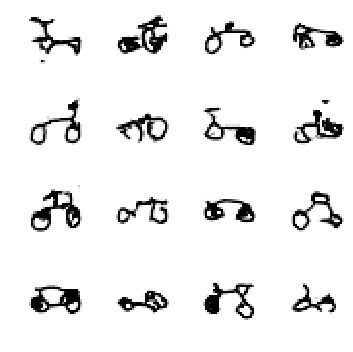

19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
Epoch #20001
20000: [D loss: 0.630695, acc: 0.666617]  [A loss: 1.242027, acc: 0.139637]


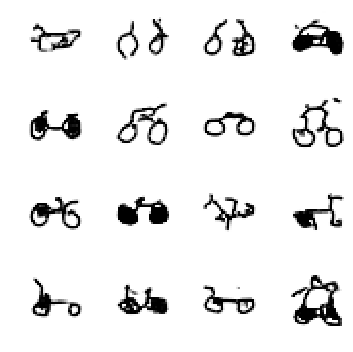

20100
20200
20300
20400
20500
20600
20700
20800
20900
21000
Epoch #21001
21000: [D loss: 0.633394, acc: 0.663409]  [A loss: 1.227293, acc: 0.141475]


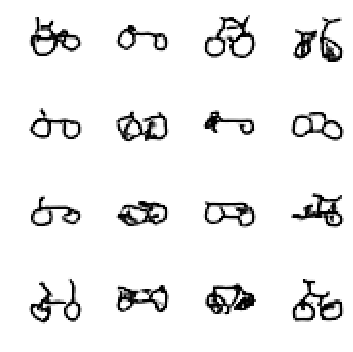

21100
21200
21300
21400
21500
21600
21700
21800
21900
22000
Epoch #22001
22000: [D loss: 0.635982, acc: 0.660249]  [A loss: 1.213019, acc: 0.143481]


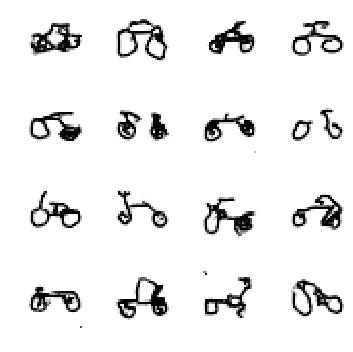

22100
22200
22300
22400
22500
22600
22700
22800
22900
23000
Epoch #23001
23000: [D loss: 0.638476, acc: 0.657158]  [A loss: 1.199479, acc: 0.145242]


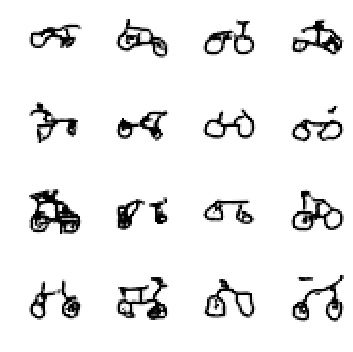

23100
23200
23300
23400
23500
23600
23700
23800
23900
24000
Epoch #24001
24000: [D loss: 0.640819, acc: 0.654219]  [A loss: 1.186701, acc: 0.146969]


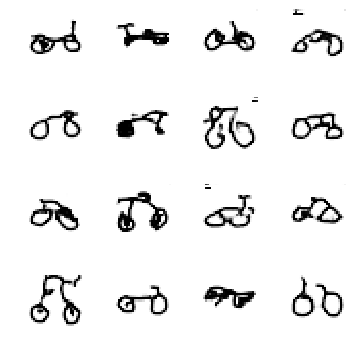

24100
24200
24300
24400
24500
24600
24700
24800
24900


In [0]:
a_metrics_complete, d_metrics_complete = train(epochs=25000, batch=128)

In [0]:
save_GAN(adversarial_model,discriminator,generator)

Text(0, 0.5, 'Loss')

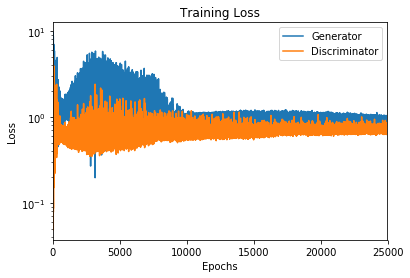

In [0]:
ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

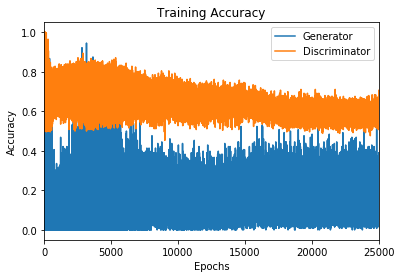

In [0]:
ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

#### Final training for model and results

In [0]:
# load weights if the model is trained previously
# load_GAN_weights(adversarial_model,discriminator,generator)
# a_metrics_complete, d_metrics_complete = train(epochs=25000, batch=128)
# we trained the model 25000 times so overally we have trained the mode for 50000 epochs
# the results of this block are deleted by accident

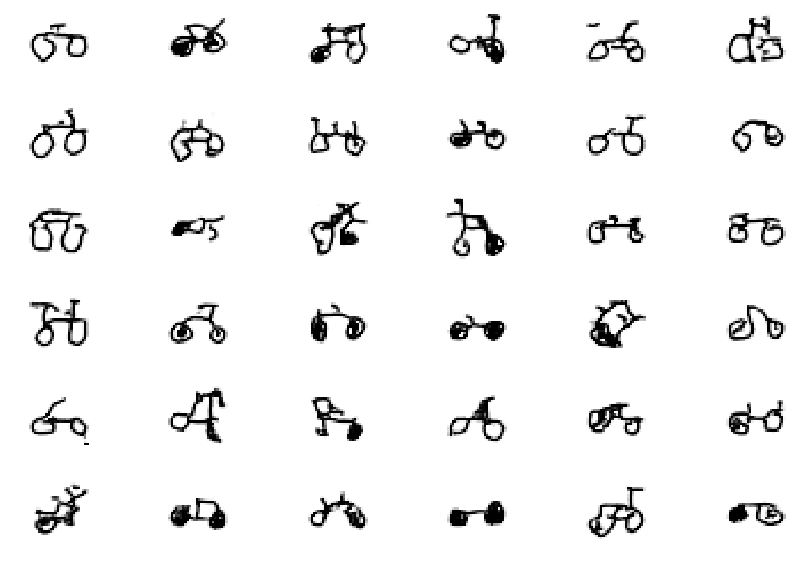

<Figure size 432x288 with 0 Axes>

In [20]:
# load model
# for the final model we have trained model for 50000(=25000+25000) epochs
load_GAN_weights(adversarial_model,discriminator,generator)
# generate images
noise = np.random.uniform(-1.0, 1.0, size=[36, z_dim])
gen_imgs = generator.predict(noise)

plt.figure(figsize=(12,8))

for k in range(gen_imgs.shape[0]):
  plt.subplot(6, 6, k+1)
  plt.imshow(gen_imgs[k, :, :, 0], cmap='Greys')
  plt.axis('off')
                
plt.tight_layout()
plt.show()
plt.savefig("/gdrive/My Drive/Colab Notebooks/GAN-generated-bicycles.png")